In [25]:
import catboost
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv
from itertools import product, chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pylab import rcParams
from mlxtend.preprocessing import DenseTransformer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

from paramsearch import paramsearch
import util
reload(util)
from util import plot_top_features, crossvaltest, catboost_param_tune



# matplotlib settings
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'

In [2]:
# ! pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
n_time = 3
n_folds = 5

## Loading the data

In [4]:
data = pd.read_csv('../data/housing_russia/train.csv')
data.head(2)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000


### Data cleaning and new feature creation

In [5]:
def split_timestamp(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    df['day'] = df.timestamp.dt.day
    df['month'] = df.timestamp.dt.month
    df['year'] = df.timestamp.dt.year
    df['quarter'] = np.ceil(df['month'] / 3).astype(int)

split_timestamp(data)

In [6]:
data = data[data.full_sq < 5000]
data = data[data.life_sq < 5000]
data = data[(data.build_year < 2017) & (data.build_year > 1700)]

In [7]:
df_train, df_test, y_train, y_test = train_test_split(data, data.price_doc, test_size = 0.2,
                                                     shuffle = True)
df_train.is_copy = False
df_test.is_copy = False

In [8]:
# run once only
y_train, y_test = np.log1p(y_train), np.log1p(y_test)

df_train = df_train.drop(['price_doc', 'timestamp', 'id'], axis = 1)
df_test = df_test.drop(['timestamp', 'id'], axis = 1)

In [9]:
cat_features = list(df_train.select_dtypes(include=['object']).columns.values)
cat_features.extend(['floor', 'max_floor', 'num_room'])
df_train[cat_features] = df_train[cat_features].astype(str)
df_test[cat_features] = df_test[cat_features].astype(str)

cat_indices = [df_train.columns.get_loc(name) for name in cat_features]

## Exploratory Data Analysis
### Data statistics

In [10]:
print ("number of training instances = {0}".format(df_train.shape[0]))
print ("number of features = {0}".format(df_train.shape[1]))
print ("number of categorical features = {0}".format(len(cat_indices)))

number of training instances = 12231
number of features = 293
number of categorical features = 18


#### Price distribution (log scale)

In [11]:
print("mean = {0}, std_dev = {1}".format(np.mean(y_train), np.std(y_train)))

mean = 15.6887966385, std_dev = 0.639511500069


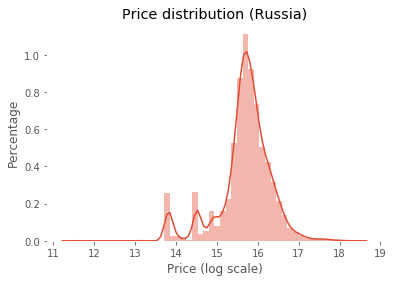

In [12]:
sns.distplot(y_train, norm_hist=True)
plt.xlabel('Price (log scale)')
plt.ylabel('Percentage')
plt.title('Price distribution (Russia)')
plt.show()

# Catboost: training and evaluating

RMSLE is chosen as our primary evaluation metric. 

The easiest way to use it is to use already implemented in most of the libraries metric RMSE on the $\ln(1 + y)$, where $y$ is the actual price.

In [42]:
pool_train = Pool(df_train, label = y_train, cat_features=cat_indices)
pool_test = Pool(df_test, cat_features=cat_indices)

In [43]:
model = CatBoostRegressor(loss_function = 'RMSE', custom_metric = 'RMSE',  calc_feature_importance = True)

<IPython.core.display.Javascript object>

In [44]:
%%notify
model.fit(pool_train, logging_level='Silent')

<IPython.core.display.Javascript object>

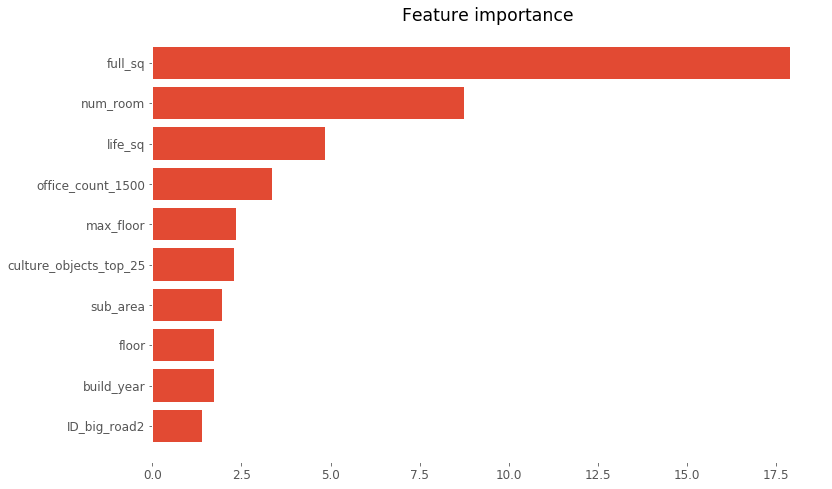

In [45]:
top_features = plot_top_features(model, pool_train.get_feature_names(), 10)

### Evaluation

In [55]:
cv_params = model.get_params()
cv_params['logging_level'] = 'Silent'
del cv_params['calc_feature_importance']

In [ ]:
%%notify
av_time = 0
for i in range(0, n_time):
    t = time.time()
    cv_data = cv(cv_params, pool_train, fold_count=n_folds, shuffle = True)
av_time += time.time() - t

In [ ]:
print('average cv time (CatBoost) = {0:.2f}'.format(av_time / n_time))
print('RMLSE (CatBoost) = {0}'.format(cv_data['RMSE_test_avg'][-1])) 

In [ ]:
cat_grid_params = {
    'depth': [1, 2, 3],
    'learning_rate': [0.1, 0.05, 0.01],
    'iterations' : [100, 500, 1000]
}
best_params = catboost_param_tune(cat_grid_params, df_train, y_train, cat_indices, 5)
print(best_params)

### Tuned version (with the best parameters found with grid search)

In [ ]:
%%notify
model = CatBoostRegressor(**best_params)
cv_params = model.get_params()
del cv_params['calc_feature_importance']


av_time = 0
for i in range(0, n_time):
    t = time.time()
    cv_data = crossvaltest(cv_params, df_train, y_train, cat_indices, n_folds)
    av_time += time.time() - t

In [ ]:
print('average cv time (CatBoost) = {0:.2f}'.format(av_time / n_time))
print('RMSLE (CatBoost) = {0}'.format(-cv_data)) 

### Feature importance

In [ ]:
model.fit(pool_train, logging_level='Silent')

In [ ]:
top_features = plot_top_features(model, pool_train, 20)

# XGBoost

In [47]:
df_train_dummy = pd.get_dummies(df_train, columns = cat_features)

In [48]:
xgboost_clf = Pipeline([('to_dense', DenseTransformer()), 
                        ('clf', xgb.XGBRegressor(eval_metric = 'rmse'))])
_ = xgboost_clf.fit(df_train_dummy, y_train)

In [15]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    xgboost_cv = cross_val_score(xgboost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [16]:
print('average cv time (XGBoost) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (XGBoost) = {0}'.format(np.sqrt(-xgboost_cv.mean())))

average cv time (XGBoost) = 47.72 sec
RMSLE (XGBoost) = 0.509707318207


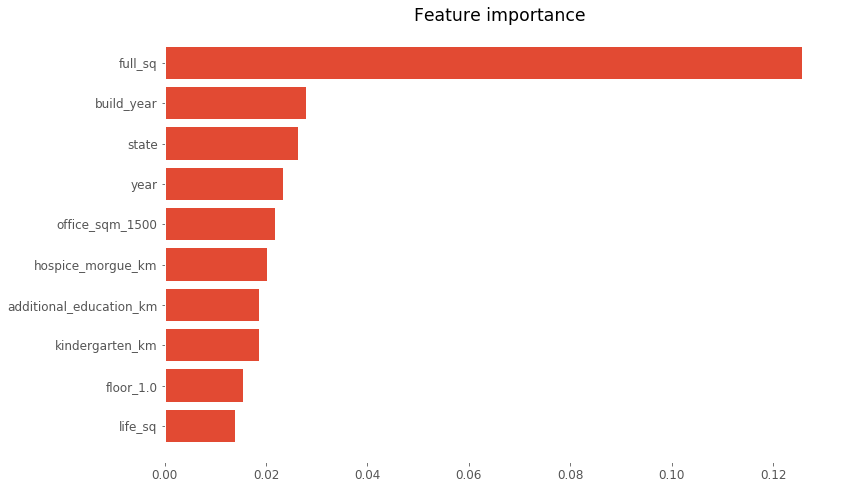

In [49]:
_ = plot_top_features(xgboost_clf.named_steps['clf'], df_train_dummy.columns.values, 10)

In [20]:
grid_params = {
    'clf__max_depth': [1, 2, 3],
    'clf__learning_rate': [0.1, 0.05, 0.01],
    'clf__n_estimators' : [100, 500, 1000]
}

In [26]:
grid_search_xgb = GridSearchCV(xgboost_clf, grid_params, scoring='neg_mean_squared_error', 
                               cv=n_folds, verbose=False)
_ = grid_search_xgb.fit(df_train_dummy, y_train)

In [27]:
best_parameters_xgb = max(grid_search_xgb.grid_scores_, key=lambda x: x[1])[0]
best_parameters_xgb

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 500}

### Tuned version (with the best parameters found with grid search)

In [28]:
xgboost_clf = Pipeline([('to_dense', DenseTransformer()), 
                        ('clf', xgb.XGBRegressor(eval_metric = 'rmse', 
                                                 learning_rate = best_parameters_xgb['clf__learning_rate'], 
                                                 n_estimators = best_parameters_xgb['clf__n_estimators'],
                                                 max_depth = best_parameters_xgb['clf__max_depth']))])

In [29]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    xgboost_cv = cross_val_score(xgboost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [30]:
print('average cv time (XGBoost) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (XGBoost) = {0}'.format(np.sqrt(-xgboost_cv.mean())))

average cv time (XGBoost) = 158.67 sec
RMSLE (XGBoost) = 0.508731104867


# GradientBoostingRegressor

In [50]:
sk_boost_clf = Pipeline([('replace_nan', Imputer()),
                        ('to_dense', DenseTransformer()), 
                        ('clf', GradientBoostingRegressor())])

In [51]:
_ = sk_boost_clf.fit(df_train_dummy, y_train)

In [32]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    sklearn_cv = cross_val_score(sk_boost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [33]:
print('average cv time (GradientBoostingRegressor) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (GradientBoostingClassifier) = {0}'.format(np.sqrt(-sklearn_cv.mean())))

average cv time (GradientBoostingRegressor) = 148.41 sec
RMSLE (GradientBoostingClassifier) = 0.510971801831


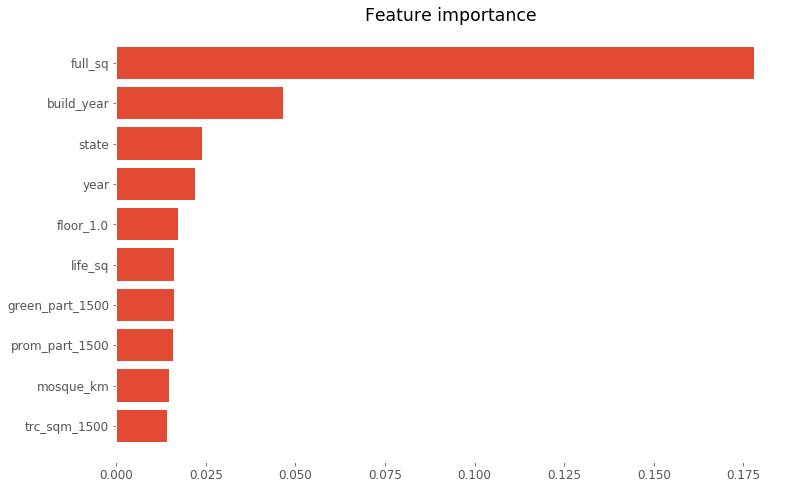

In [52]:
_ = plot_top_features(sk_boost_clf.named_steps['clf'], df_train_dummy.columns.values, 10)

In [37]:
grid_search_sk = GridSearchCV(sk_boost_clf, grid_params, scoring='neg_mean_squared_error', 
                               cv=n_folds, verbose=True)
_ = grid_search_sk.fit(df_train_dummy, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 514.0min finished


In [38]:
best_parameters_sk = max(grid_search_sk.grid_scores_, key=lambda x: x[1])[0]
best_parameters_sk

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__n_estimators': 1000}

### Tuned version (with the best parameters found with grid search)

In [39]:
sk_boost_clf = Pipeline([('replace_nan', Imputer()),
                        ('to_dense', DenseTransformer()), 
                        ('clf', GradientBoostingRegressor(learning_rate = best_parameters_sk['clf__learning_rate'], 
                                                 n_estimators = best_parameters_sk['clf__n_estimators'],
                                                 max_depth = best_parameters_sk['clf__max_depth']))])

In [40]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    sklearn_cv = cross_val_score(sk_boost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [41]:
print('average cv time (GradientBoostingRegressor) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (GradientBoostingRegressor) = {0}'.format(np.sqrt(-sklearn_cv.mean())))

average cv time (GradientBoostingRegressor) = 474.05 sec
RMSLE (GradientBoostingRegressor) = 0.509749214223
